In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
sns.set_palette('colorblind')
sns.set_color_codes(palette='colorblind')

In [2]:
res_dir = 'results/toy'
scale_dir = 'results/toy/scaled'
model_desc_temp = '{}-lrelu_hsize-100'
data_desc_temp = 'num2-6_input-{}_{}_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000'
train_desc_temp = 'loss-{}_drop0.5_500eps'
fs = 20
nreps = 11
figsize=(5.5, 4)

In [8]:
def get_train_results(nreps, model_desc, data_desc, train_desc):
    
    train_results = []
    for rep in range(nreps):
        print(f'Rep {rep}')
        train_desc_rep = train_desc + f'_rep{rep}'
        # Look in scaled dir first, then normal results
        tr_file = f'{scale_dir}/toy_results_{model_desc}_{data_desc}_{train_desc_rep}.pkl'
        if not os.path.exists(tr_file):
            tr_file = f'{res_dir}/toy_results_{model_desc}_{data_desc}_{train_desc_rep}.pkl'
        try:
            data = pd.read_pickle(tr_file)
#             print(f'Loading {tr_file}')
            data = data[data['dataset'] == 'train']
            data = data.drop(columns=['shape loss', 'rnn iterations'])
            data['repetition'] = rep
            train_results.append(data)
        except FileNotFoundError:
            print(f'Missing {tr_file}')
    if len(train_results) > 1:
        tr_data = pd.concat(train_results, ignore_index=True)
    else:
        tr_data = train_results[0]
    return tr_data

def get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=False):
    shapes_map = {'[0, 1, 2, 3, 4]': 'same as training', '[5, 6, 7, 8, 9]': 'new'}
    lums_map = {'[0.0, 0.5, 1.0]': 'same as training', '[0.1, 0.3, 0.7, 0.9]': 'new'}
    results = []
    for rep in range(0, nreps):
        print(f'Rep {rep}')
        train_desc_rep = train_desc + f'_rep{rep}'
        # Look in scaled dir first
        te_file = f'{scale_dir}/detailed_test_results_{model_desc}_{data_desc}_{train_desc_rep}.pkl'
        if not os.path.exists(te_file):
            te_file = f'{res_dir}/detailed_test_results_{model_desc}_{data_desc}_{train_desc_rep}.pkl'
#         print(f'Loading {te_file}')
        try:
            data = pd.read_pickle(te_file)
        except FileNotFoundError:
            print(f'Missing {te_file}')
            continue
        if 'test_shapes' in data.columns:
            data = data.drop(columns=['test_shapes', 'train_shapes'])
#         data = data.rename(columns={"test shapes": "Shapes", "test lums": "Luminance"})
        data['Test Shapes'] = data['test shapes'].apply(lambda x: shapes_map[x])
        data['Test Luminance'] = data['test lums'].apply(lambda x: lums_map[x])
        
        if pass_count:
            data = data[data['Test Shapes'] == 'new']           
            data = data[data['Test Luminance'] == 'new']
            data = data.rename(columns={'pass count': 'Integration Score'})
            mean_data = data.groupby(['epoch', 'Integration Score', 'repetition']).mean()
        else:
            mean_data = data.groupby(['epoch', 'Test Shapes', 'Test Luminance', 'repetition']).mean()
        results.append(mean_data)
    if len(results > 1):
        te_data = pd.concat(results)
    else:
        te_data = results[0]
    te_data = te_data.reset_index()
    return te_data

def get_confusion(model_desc, data_desc, train_desc):
    confs = []
    for rep in range(1, nreps):
        print(f'Rep {rep}')
        train_desc_rep = train_desc + f'_rep{rep}'
        # Look in scaled dir first
        conf_file = f'{scale_dir}/confusion_{model_desc}_{data_desc}_{train_desc_rep}.npy'
        try:
            conf = np.load(conf_file)
            confs.append(conf)
        except FileNotFoundError:
            print(f'Misssing {conf_file}')
    confs = np.array(confs)
    return confs
            
    

# def plot_accuracy(tr_results, te_results, legend=True, pass_count=False, loc='lower'):

#     tr = sns.lineplot(data=tr_results, x='epoch', y='accuracy', linestyle=':', linewidth=3, color='g', label='training accuracy', errorbar='se', legend=legend)
#     if pass_count:
#         max_pass = max(te_results['Integration Score'].max(), 6)
#         te_results = te_results[te_results['Integration Score'] < max_pass]
#         te = sns.lineplot(data=te_results, x='epoch', hue='Integration Score', y='accuracy', errorbar='se', legend=legend)
#     else:
#         te = sns.lineplot(data=te_results, x='epoch', hue='Test Shapes', style='Test Luminance', y='accuracy', errorbar='se', legend=legend)

#     if pass_count and legend:
#         h, l = te.get_legend_handles_labels()
#         first_legend = plt.legend(handles=[h[0]], loc=loc + ' left')
#         plt.gca().add_artist(first_legend)
#         plt.legend(handles=h[1:], title='Integration Score', loc=loc + ' right')
#     plt.ylabel('Accuracy (%)', fontsize=fs)
#     plt.xlabel('Epoch', fontsize=fs)
#     plt.ylim([10, 101])
#     plt.grid()
#     plt.tight_layout()
    
def plot_accuracy(tr_results, te_results, legend=True, pass_count=False, loc='lower'):
    fig, ax = plt.subplots(figsize=figsize)
    tr = sns.lineplot(data=tr_results, x='epoch', y='accuracy', ax=ax, linestyle=':', linewidth=3, color='g', label='training accuracy', errorbar='se', legend=legend)
    if pass_count:
        max_pass = max(te_results['Integration Score'].max(), 6)
        te_results = te_results[te_results['Integration Score'] < max_pass]
        te = sns.lineplot(data=te_results, x='epoch', hue='Integration Score', y='accuracy', ax=ax, errorbar='se', legend=legend)
    else:
        te = sns.lineplot(data=te_results, x='epoch', hue='Test Shapes', style='Test Luminance', ax=ax, y='accuracy', errorbar='se', legend=legend)

    if pass_count and legend:
        h, l = te.get_legend_handles_labels()
        first_legend = ax.legend(handles=[h[0]], loc=loc + ' left')
        ax.add_artist(first_legend)
        ax.legend(handles=h[1:], title='Integration Score', loc=loc + ' right')
    ax.set_ylabel('Accuracy (%)', fontsize=fs)
    ax.set_xlabel('Epoch', fontsize=fs)
    ax.set_ylim([10, 101])
    ax.grid()
    fig.tight_layout()

def plot_loss(tr_results, te_results, legend=True, pass_count=False, loc='lower'):
    # If plotting both losses
    if te_results['map loss'][0] > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    #     ax1.plot(tr_results['loss'], ':', color='green', label='training loss')
        try:
            sns.lineplot(data=tr_results, x='epoch', y='num loss', ax=ax1, legend=False, errorbar='se', linestyle=':', linewidth=3, color='g')
        except:
            print('Missing train num loss')
        sns.lineplot(data=tr_results, x='epoch', y='map loss', ax=ax2, legend=legend, errorbar='se', linestyle=':', linewidth=3, label='training loss', color='g')

        if pass_count:
            max_pass = max(te_results['Integration Score'].max(), 6)
            te_results = te_results[te_results['Integration Score'] < max_pass]
            sns.lineplot(data=te_results, x='epoch', y='num loss', hue='Integration Score', ax=ax1, legend=False, errorbar='se')
            te = sns.lineplot(data=te_results, x='epoch', y='map loss', hue='Integration Score', ax=ax2, legend=legend, errorbar='se')
            if legend:
                h, l = te.get_legend_handles_labels()
                first_legend = plt.legend(handles=[h[0]], loc='lower left')
                plt.gca().add_artist(first_legend)
                plt.legend(handles=h[1:], title='Integration Score', loc='upper right')
        else:
            sns.lineplot(data=te_results, x='epoch', y='num loss', hue='Test Shapes', style='Test Luminance', ax=ax1, legend=False, errorbar='se')
            sns.lineplot(data=te_results, x='epoch', y='map loss', hue='Test Shapes', style='Test Luminance', ax=ax2, legend=legend, errorbar='se')
    
        ax1.set_ylabel('Number Loss', fontsize=fs)
        ax1.set_xlabel('Epoch', fontsize=fs)
        ylim = ax1.get_ylim()
        ax1.set_ylim([-0.02, ylim[1]])
        ax1.grid()
        ylim = ax2.get_ylim()
        ax2.set_ylim([-0.01, ylim[1]])
        ax2.set_ylabel('Map Loss', fontsize=fs)
        ax2.set_xlabel('Epoch', fontsize=fs)
        ax2.grid()
        fig.tight_layout()
    else: # Plot only num loss
        fig, ax = plt.subplots(figsize=figsize)
        try:
            sns.lineplot(data=tr_results, x='epoch', y='num loss', legend=legend, ax=ax, errorbar='se', linestyle=':', linewidth=3, color='g', label='training loss')
        except:
            sns.lineplot(data=tr_results, x='epoch', y='loss', legend=legend, ax=ax, errorbar='se', linestyle=':', linewidth=3, color='g', label='training loss')
        if pass_count:
            te = sns.lineplot(data=te_results, x='epoch', y='num loss', hue='Integration Score', ax=ax, legend=legend, errorbar='se')
        else:
            te = sns.lineplot(data=te_results, x='epoch', y='num loss', hue='Test Shapes', ax=ax, style='Test Luminance', legend=legend, errorbar='se')
        if pass_count and legend:
            h, l = te.get_legend_handles_labels()
            first_legend = plt.legend(handles=[h[0]], loc=loc + ' left')
            plt.gca().add_artist(first_legend)
            plt.legend(handles=h[1:], title='Integration Score', loc=loc + ' right')
        ax.set_ylabel('Number Loss', fontsize=fs)
        ax.set_xlabel('Epoch', fontsize=fs)
        plt.grid()
        fig.tight_layout()

def plot_confusion(confs):
    ticks = list(range(6 - 2 + 1))
    ticklabels = [str(tick + 2) for tick in ticks]
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    colorstyle = product(['orange', 'b'], ['--', '-'])
    axs = axs.flatten()
    for i, (ax, (c, s)) in enumerate(zip(axs, colorstyle)):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.matshow(confs[i], cmap='Greys', vmin=0, vmax=1000)
        ax.set_aspect('equal', adjustable='box')
#         ax.set_title(f'test shapes={shape} lums={lum}')
        ax.set_xticks(ticks, ticklabels, fontsize=16)
        ax.set_xlabel('Predicted Class', fontsize=18)
        ax.set_ylabel('True Class', fontsize=18)
        ax.set_yticks(ticks, ticklabels, fontsize=16)
        rect = plt.Rectangle((-0.5, -0.5), 5,5, fill=False, color=c, linewidth=8, linestyle=s)
        ax.add_patch(rect)
        # Plot accuracies along the diagonal
        accs = np.diag(confs[i])/ 10
        for x, acc in enumerate(accs):
            ax.text(x-0.35, x+0.05, f'{acc:.0f}%', color='y', fontsize=16, weight="bold")
        # ax2 = ax.twinx()
        # ax2.set_yticks(ticks, np.sum(confs[i], axis=1))
    fig.tight_layout()
    

# Figure 2 components

## Recurrent glimpse net

In [282]:
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('both')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')

In [283]:
tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
te_results = get_test_results(nreps, model_desc, data_desc, train_desc)

Rep 0
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


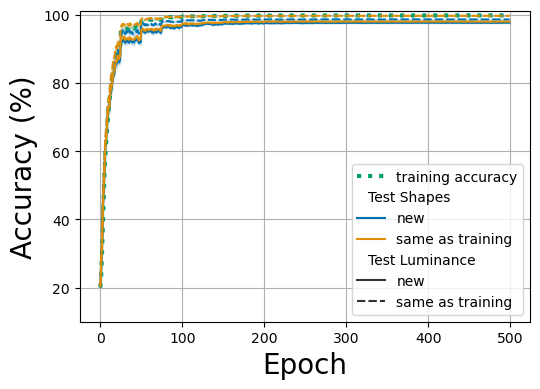

In [321]:
plot_accuracy(tr_results, te_results, loc='lower')
plt.savefig('figures/workshop/RGN_accuracy.svg', dpi=300)

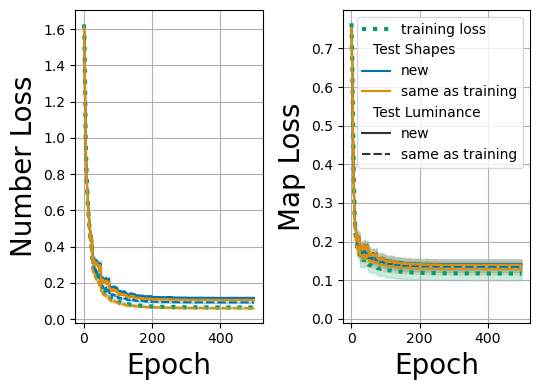

In [320]:
plot_loss(tr_results, te_results)
plt.savefig('figures/workshop/RGN_loss.svg', dpi=300)

Rep 1
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep1.npy
Rep 2
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.npy
Rep 3
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.npy
Rep 4
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep4.npy
Rep 5
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps

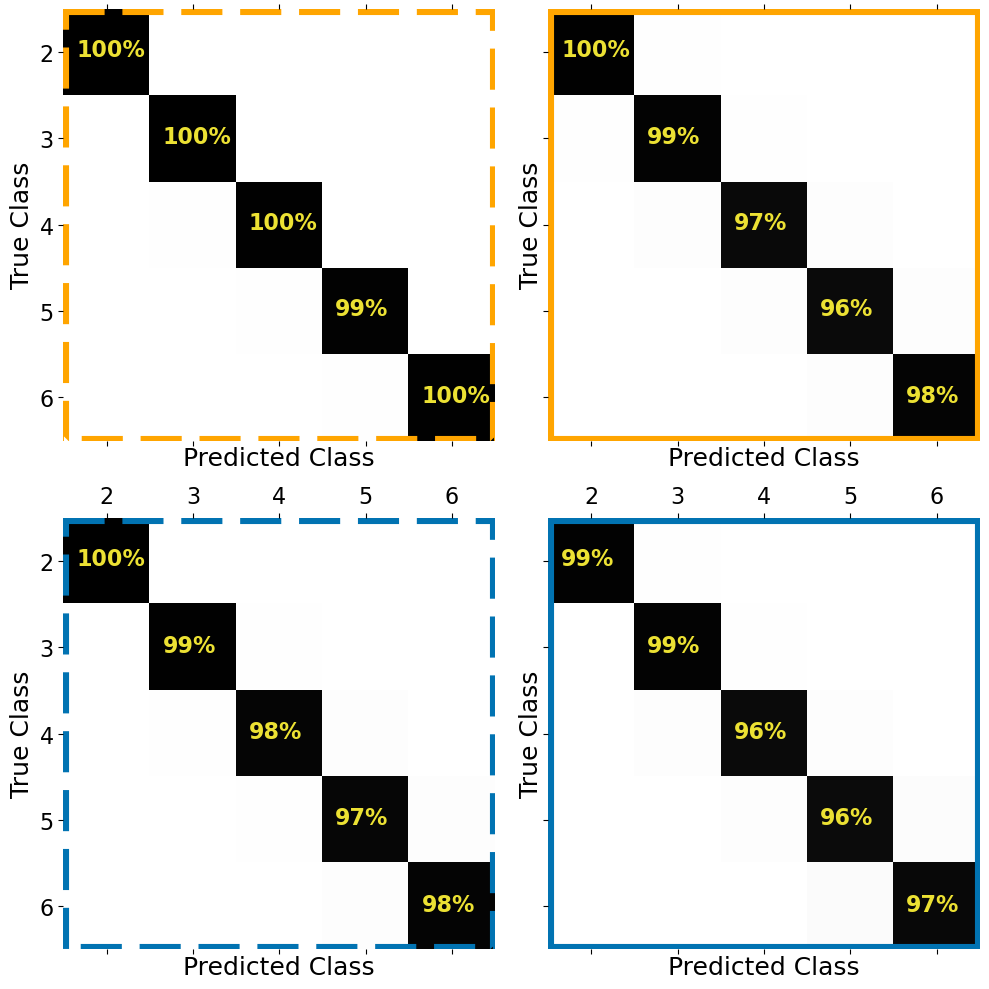

In [324]:
# Plot confusion matrix
confs = get_confusion(model_desc, data_desc, train_desc)
plot_confusion(confs.mean(axis=0))
plt.savefig('figures/workshop/rgn_conf.svg', dpi=300)

## CNN baseline

In [325]:
model_desc = model_desc_temp.format('cnn2')
data_desc = data_desc_temp.format('shape')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('num')

In [326]:
cnn_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
cnn_te_results = get_test_results(nreps, model_desc, data_desc, train_desc)

Rep 0
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


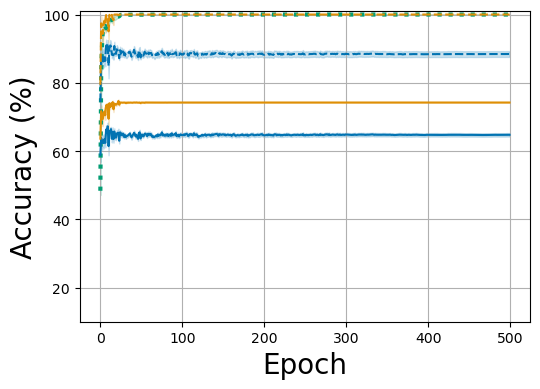

In [327]:
plot_accuracy(cnn_tr_results, cnn_te_results, False)
plt.savefig('figures/workshop/CNN_accuracy.svg', dpi=300)

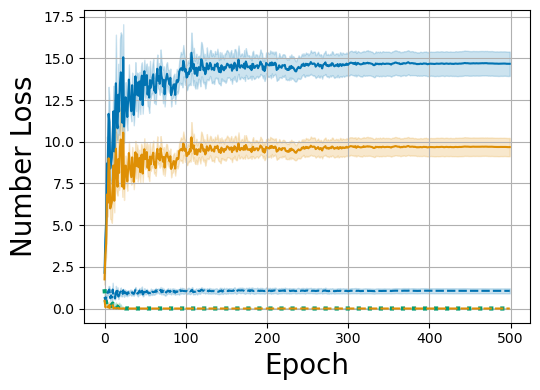

In [328]:
plot_loss(cnn_tr_results, cnn_te_results, False)
plt.savefig('figures/workshop/CNN_loss.svg', dpi=300)

Rep 1
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep1.npy
Rep 2
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep2.npy
Rep 3
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep3.npy
Rep 4
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep4.npy
Rep 5
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep5.npy
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


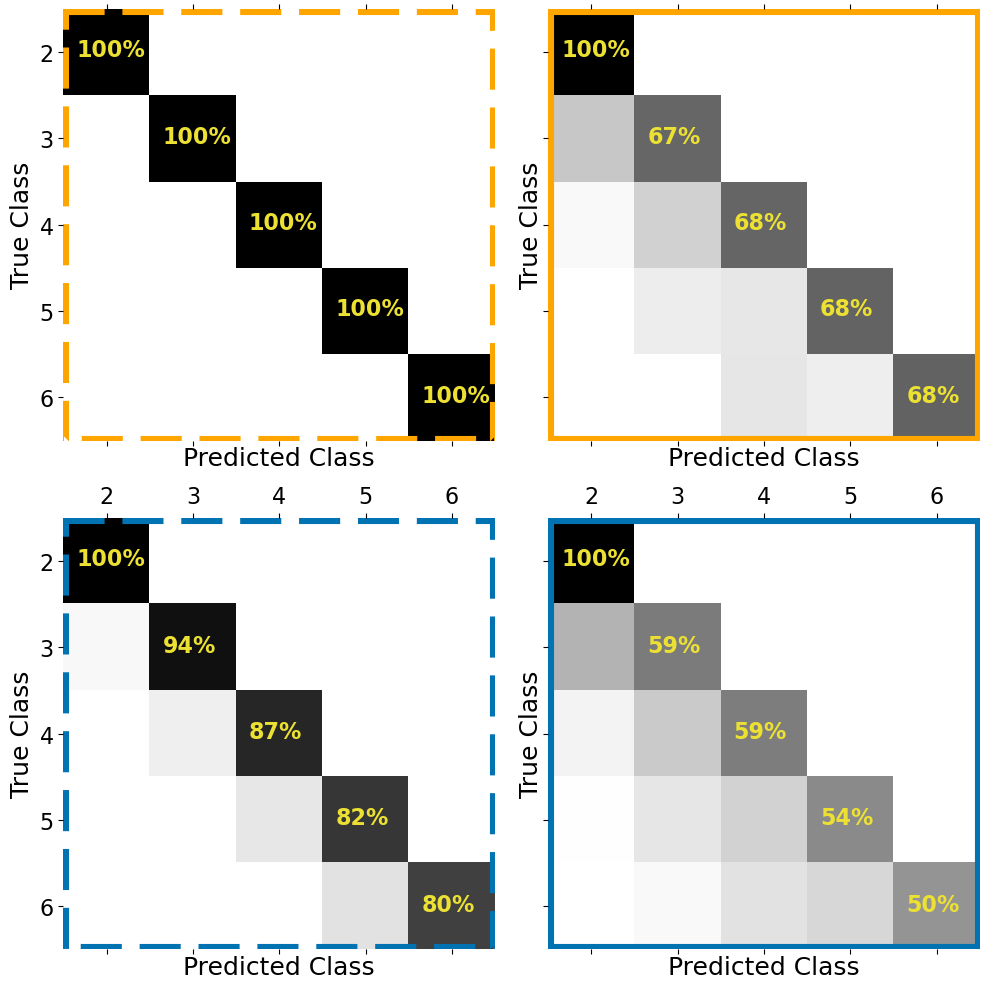

In [329]:
# Plot confusion matrix
confs = get_confusion(model_desc, data_desc, train_desc)
plot_confusion(confs.mean(axis=0))
plt.savefig('figures/workshop/CNN_conf.svg', dpi=300)

# Figure 3 Components
## Full RGN

In [4]:
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('both', 'pixel_std')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')

In [9]:
rgn_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
rgn_te_results = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

Rep 0
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_pixel_std_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep0.pkl
Rep 1
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_pixel_std_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep1.pkl
Rep 2
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_pixel_std_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_pixel_std_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl
Rep 4
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_pixel_std_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep4

IndexError: list index out of range

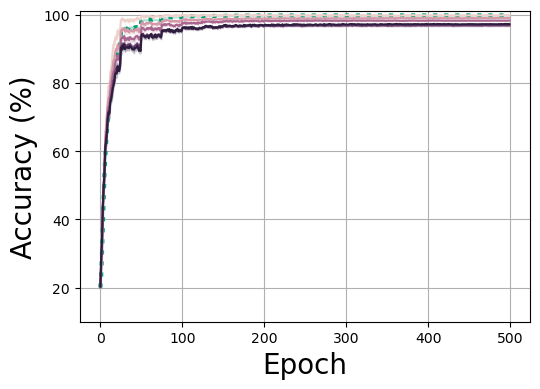

In [340]:
plot_accuracy(tr_results, rgn_te_results, legend=False, pass_count=True, loc='lower')
plt.savefig('figures/workshop/RGN_byscore_accuracy.svg', dpi=300)
# sns.lineplot(data=te_results[te_results['Integration Score']==6], x='epoch', hue='Integration Score', y='accuracy', style='repetition', errorbar='se', legend=True)

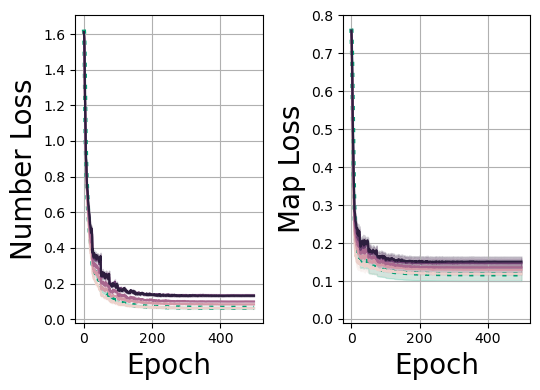

In [333]:
plot_loss(tr_results, rgn_te_results, legend=False, pass_count=True, loc='lower')
plt.savefig('figures/workshop/RGN_byscore_loss.svg', dpi=300)

In [334]:
# Input = pixels only
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('shape')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')
pix_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
pix_te_results = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

Rep 0
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


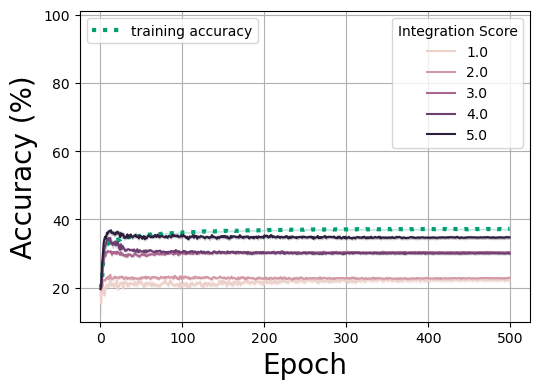

In [335]:
plot_accuracy(pix_tr_results, pix_te_results, legend=True, pass_count=True, loc='upper')
plt.savefig('figures/workshop/RGN_pix_accuracy.svg', dpi=300)
# tr = sns.lineplot(data=tr_results, x='epoch', y='accuracy', linestyle=':', linewidth=3, color='g', label='training accuracy', errorbar='se', legend=True)
# te = sns.lineplot(data=te_results, x='epoch', hue='Integration Score', y='accuracy', errorbar='ci', legend=True)
# plt.savefig('figures/workshop/RGN_pix-both_accuracy.svg', dpi=300)

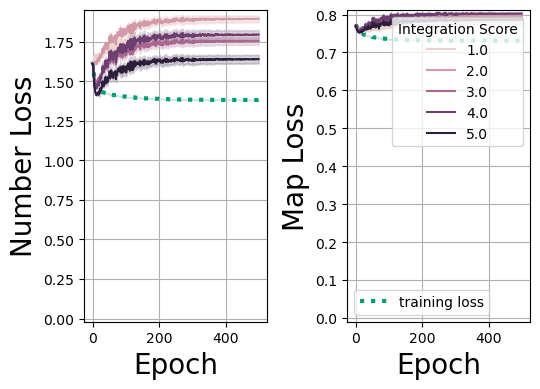

In [336]:
plot_loss(pix_tr_results, pix_te_results, legend=True, pass_count=True)
plt.savefig('figures/workshop/RGN_pix_loss.svg', dpi=300)

In [337]:
# xy only
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('xy')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')
xy_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
xy_te_results = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

Rep 0
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


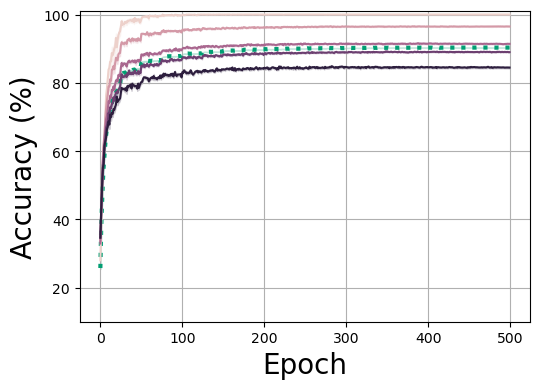

In [338]:
plot_accuracy(xy_tr_results, xy_te_results, legend=False, pass_count=True, loc='lower')
plt.savefig('figures/workshop/RGN_xy_accuracy.svg', dpi=300)

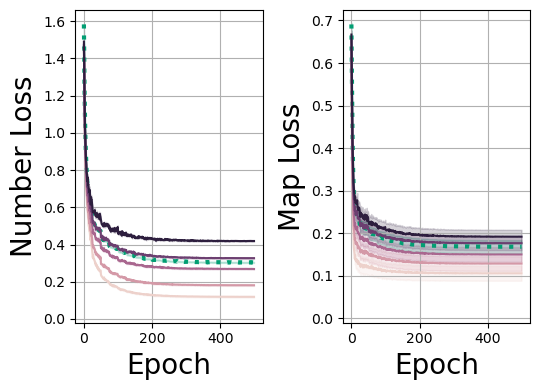

In [339]:
plot_loss(xy_tr_results, xy_te_results, legend=False, pass_count=True)
plt.savefig('figures/workshop/RGN_xy_loss.svg', dpi=300)

# Figure 4 Components - Recurrent control loss=both

In [341]:
model_desc = model_desc_temp.format('recurrent_control2')
data_desc = data_desc_temp.format('shape')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')

In [342]:
rc_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
rc_te_results = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=False)

Rep 0
Rep 1
Rep 2
Rep 3
Rep 4
Missing results/toy/toy_results_recurrent_control2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep4.pkl
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


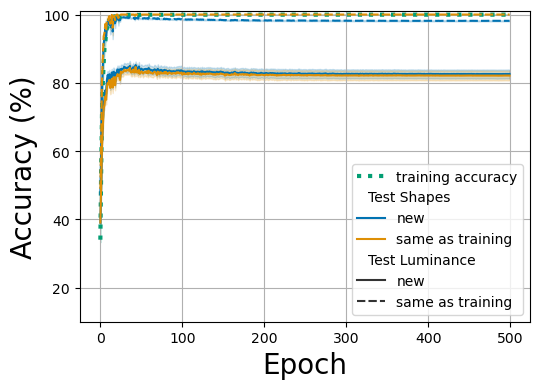

In [343]:
plot_accuracy(rc_tr_results, rc_te_results, legend=True)
plt.savefig('figures/workshop/rc_accuracy.svg', dpi=300)

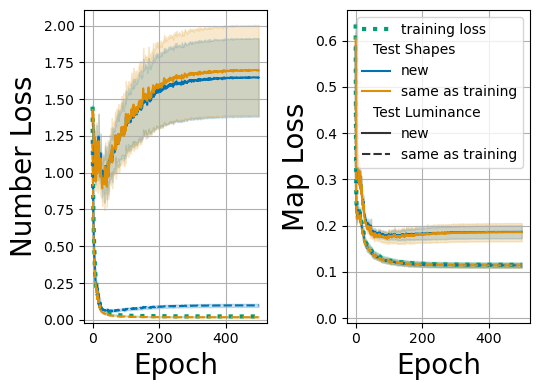

In [344]:
plot_loss(rc_tr_results, rc_te_results, legend=True)
plt.savefig('figures/workshop/rc_loss.svg', dpi=300)

Rep 1
Rep 2
Rep 3
Rep 4
Misssing results/toy/scaled/confusion_recurrent_control2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep4.npy
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


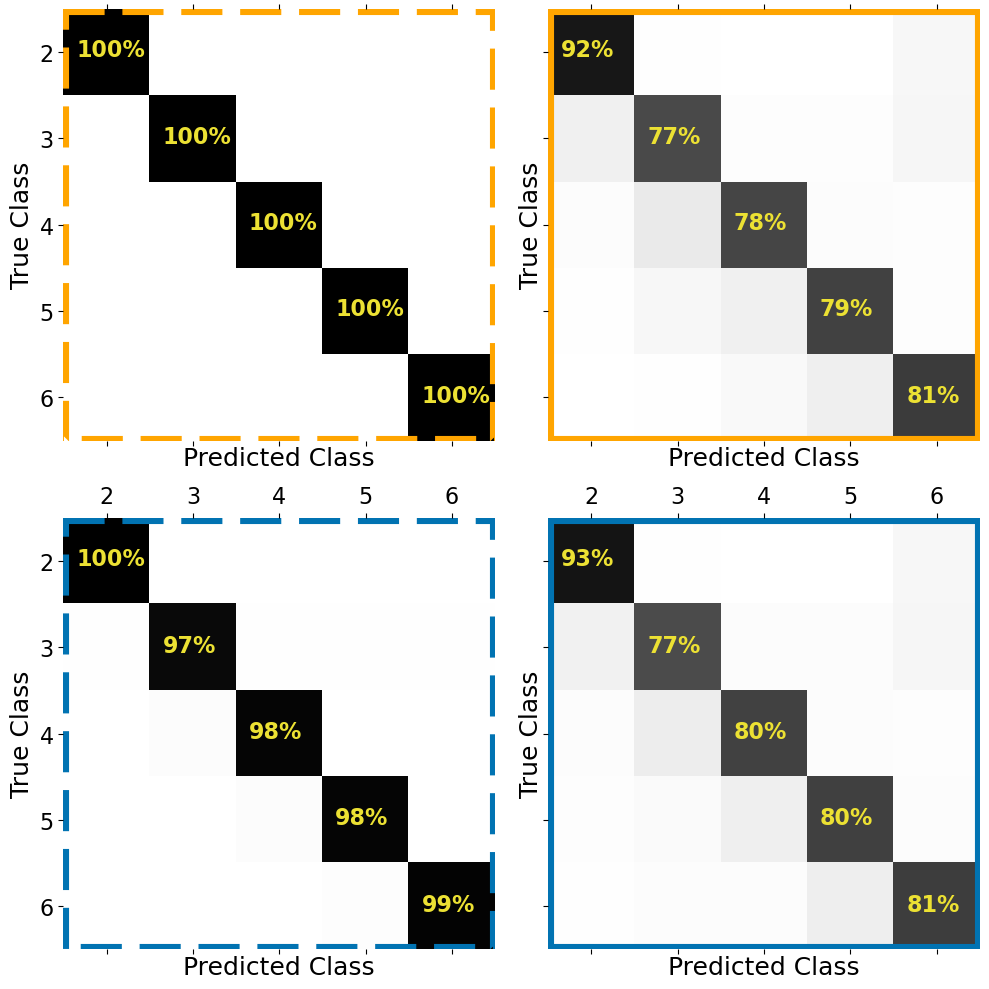

In [345]:
# Plot confusion matrix
confs = get_confusion(model_desc, data_desc, train_desc)
plot_confusion(confs.mean(axis=0))
plt.savefig('figures/workshop/RC_conf.svg', dpi=300)

# Figure 5 Components - The effect of the map

In [346]:
# RNN w/o map
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('both')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('num')


In [347]:
nomap_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
nomap_te_results = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=False)

Rep 0
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10
Rep 1
Rep 2
Rep 3
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


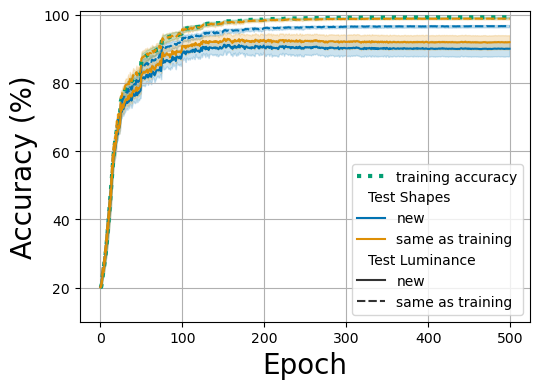

In [348]:
plot_accuracy(nomap_tr_results, nomap_te_results, legend=True)
plt.savefig('figures/workshop/RGN_nomap_accuracy.svg', dpi=300)

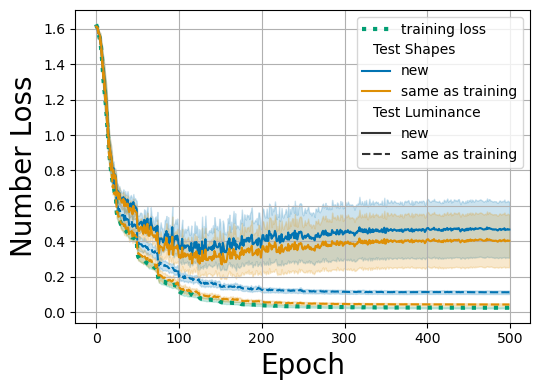

In [349]:
plot_loss(nomap_tr_results, nomap_te_results, legend=True)
plt.savefig('figures/workshop/RGN_nomap_loss.svg', dpi=300)

Rep 1
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep1.npy
Rep 2
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep2.npy
Rep 3
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep3.npy
Rep 4
Misssing results/toy/scaled/confusion_rnn_classifier2-lrelu_hsize-100_num2-6_input-both_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-num_drop0.5_500eps_rep4.npy
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


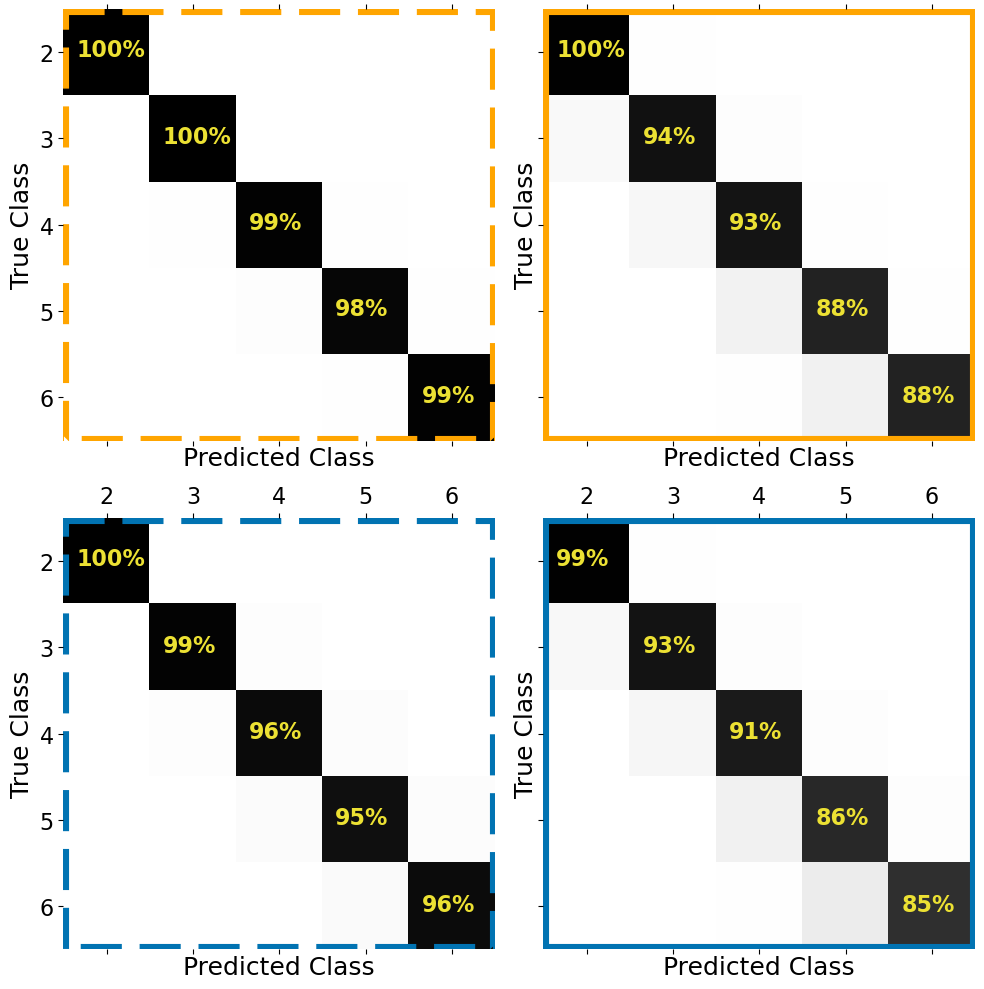

In [350]:
# Plot confusion matrix
confs = get_confusion(model_desc, data_desc, train_desc)
plot_confusion(confs.mean(axis=0))
plt.savefig('figures/workshop/RGN_nomap_conf.svg', dpi=300)

In [351]:
# CNN w/ map
model_desc = model_desc_temp.format('cnn2')
data_desc = data_desc_temp.format('shape')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')

In [352]:
mapcnn_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
mapcnn_te_results = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=False)

Rep 0
Rep 1
Rep 2
Missing results/toy/toy_results_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/toy_results_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10
Rep 1
Rep 2
Missing results/toy/detailed_test_results_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/detailed_test_results_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl
Rep 4
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


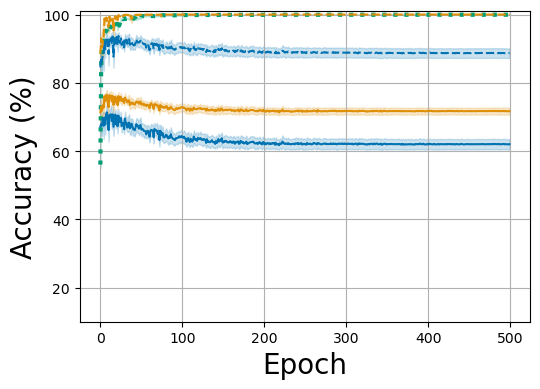

In [353]:
plot_accuracy(mapcnn_tr_results, mapcnn_te_results, legend=False)
plt.savefig('figures/workshop/mapCNN_accuracy.svg', dpi=300)

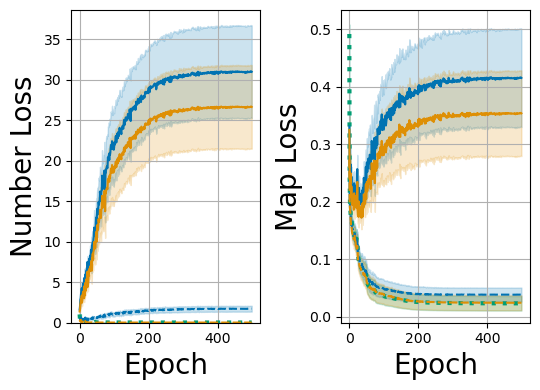

In [354]:
plot_loss(mapcnn_tr_results, mapcnn_te_results, legend=False)
plt.savefig('figures/workshop/mapCNN_loss.svg', dpi=300)

Rep 1
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep1.npy
Rep 2
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.npy
Rep 3
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.npy
Rep 4
Misssing results/toy/scaled/confusion_cnn2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]same_gw6_solarized_100000_loss-both_drop0.5_500eps_rep4.npy
Rep 5
Rep 6
Rep 7
Rep 8
Rep 9
Rep 10


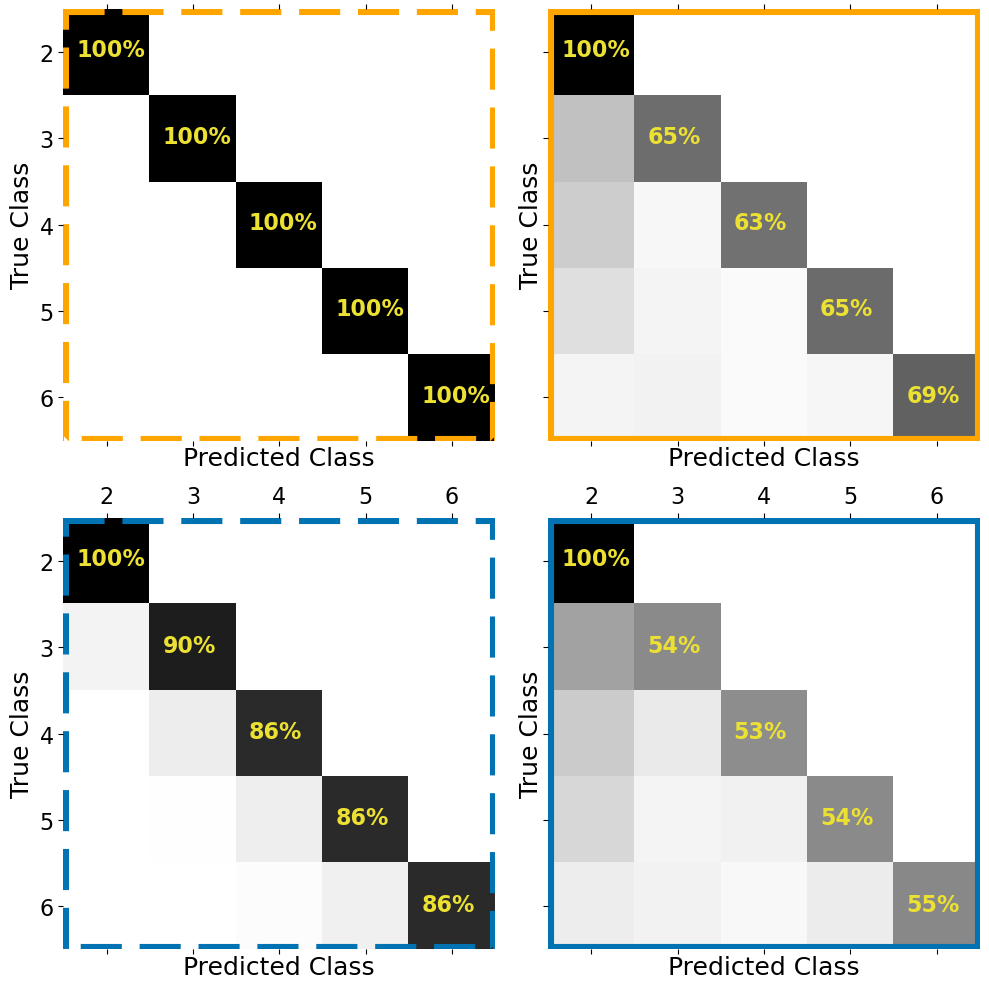

In [355]:
# Plot confusion matrix
confs = get_confusion(model_desc, data_desc, train_desc)
plot_confusion(confs.mean(axis=0))
plt.savefig('figures/workshop/mapCNN_conf.svg', dpi=300)

# Possible Figure 6 - Summary

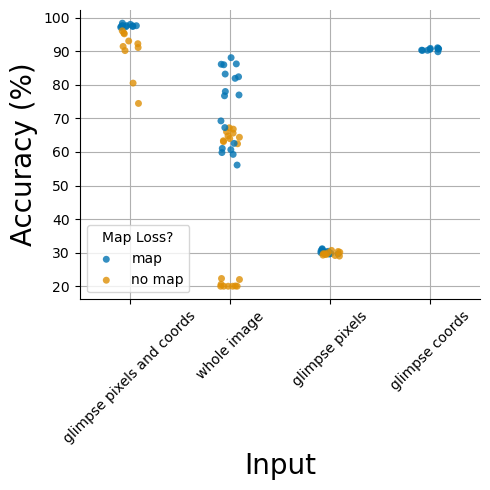

In [357]:
# y=final accuracy on hardest test set, x=input, hue=map loss
# te0 = te_results.rename(columns={'Test Shapes':'shapes', 'Test Luminance': 'lums'})
final = te_results.query('epoch==499')
final = final[(final['Test Shapes'] == 'new') & (final['Test Luminance'] == 'new') ]
final['map'] = 'map'
final['input'] = 'glimpse pixels and coords'
final['arch'] = 'recurrent'
# cnn
final1 = cnn_te_results.query('epoch==499')
final1 = final1[(final1['Test Shapes'] == 'new') & (final1['Test Luminance'] == 'new') ]
final1['map'] = 'no map'
final1['input'] = 'whole image'
final1['arch'] = 'convolutional'
# cnn + map
final2 = mapcnn_te_results.query('epoch==499')
final2 = final2[(final2['Test Shapes'] == 'new') & (final2['Test Luminance'] == 'new') ]
final2['map'] = 'map'
final2['input'] = 'whole image'
final2['arch'] = 'convolutional'
# RGN without map
final3 = nomap_te_results.query('epoch==499')
final3 = final3[(final3['Test Shapes'] == 'new') & (final3['Test Luminance'] == 'new') ]
final3['map'] = 'no map'
final3['input'] = 'glimpse pixels and coords'
final3['arch'] = 'recurrent'
# Recurrent control
final4 = rc_te_results.query('epoch==499')
final4 = final4[(final4['Test Shapes'] == 'new') & (final4['Test Luminance'] == 'new') ]
final4['map'] = 'map'
final4['input'] = 'whole image'
final4['arch'] = 'recurrent'
# Recurrent control loss=num (no map)
final5 = rcnum_te_results.query('epoch==499')
final5 = final5[(final5['Test Shapes'] == 'new') & (final5['Test Luminance'] == 'new') ]
final5['map'] = 'no map'
final5['input'] = 'whole image'
final5['arch'] = 'recurrent'
# RGN pixel only
final6 = pix_te_results.query('epoch==499')
final6 = final6.groupby(['repetition']).mean()
final6['map'] = 'map'
final6['input'] = 'glimpse pixels'
final6['arch'] = 'recurrent'
# RGN pixel only no map
final7 = pixnum_te_results.query('epoch==499')
final7 = final7.groupby(['repetition']).mean()
final7['map'] = 'no map'
final7['input'] = 'glimpse pixels'
final7['arch'] = 'recurrent'
# RGN xy only
final8 = xy_te_results.query('epoch==499')
final8 = final8.groupby(['repetition']).mean()
final8['map'] = 'map'
final8['input'] = 'glimpse coords'
final8['arch'] = 'recurrent'


df = pd.concat([final, final1, final2, final3, final4, final5, final6, final7, final8])
# sns.catplot(data=df, y='accuracy', col='arch', x='input', hue='map')
sns.catplot(data=df, y='accuracy', x='input', hue='map', legend=False, alpha=0.8, )
# sns.catplot(data=df, y='accuracy', col='input', x='arch', hue='map')
plt.ylabel('Accuracy (%)', fontsize=fs)
plt.xlabel('Input', fontsize=fs)
plt.xticks(rotation=45)
plt.legend(['map', 'no map'], title='Map Loss?', loc='lower left')
plt.grid()
plt.tight_layout()
plt.savefig('figures/workshop/fig6.png', dpi=300)


In [ ]:
final6

# Supplemental figures
## Recurrent control - num

In [ ]:
model_desc = model_desc_temp.format('recurrent_control2')
data_desc = data_desc_temp.format('shape')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('num')
rcnum_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
rcnum_te_results = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=False)

In [ ]:
plot_accuracy(rcnum_tr_results, rcnum_te_results, legend=False)
plt.savefig('figures/workshop/rcnum_accuracy.svg', dpi=300)

In [ ]:
plot_loss(rcnum_tr_results, rcnum_te_results, legend=False)
plt.savefig('figures/workshop/rcnum_loss.svg', dpi=300)

## RGN input=shape loss=num

In [ ]:
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('shape')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('num')

pixnum_tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
pixnum_te_results = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

In [ ]:
plot_accuracy(pixnum_tr_results, pixnum_te_results, legend=True, pass_count=True, loc='upper')
plt.savefig('figures/workshop/rgn_pix_num_accuracy.svg', dpi=300)

In [ ]:
pixnum_te_results.columns

In [ ]:
plot_loss(pixnum_tr_results, pixnum_te_results, legend=False, pass_count=True)
plt.savefig('figures/workshop/rgn_pix_num_loss.svg', dpi=300)

# Not same

In [ ]:
same_data_desc_temp = 'num2-6_input-{}_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000'

In [ ]:
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = same_data_desc_temp.format('both')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')
tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
te_results = get_test_results(nreps, model_desc, data_desc, train_desc)
